# MMA 831 DOS 2 - Version 4 (likely final)

Nick Nguyen - Updated July 26th, 2019

Final version of the DOS 2 code, updated 12:08AM on July 26th.

In this version:
* EDA and visualizations
* Data Cleaning/Preprocessing (for `apriori`)
* Market Basket Analysis using `apriori`
* Building association rules
* Homemade visualizations
* Recommender system using `LightFM` and a custom home-brewed function to go along with it.

## Import Packages

In [85]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

import seaborn as sns

## Import Data

In [86]:
%time dat = pd.read_excel('Online Retail.xlsx')

CPU times: user 1min 6s, sys: 500 ms, total: 1min 7s
Wall time: 1min 7s


## Explore Data

In [87]:
dat.shape

(541909, 8)

In [88]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [89]:
dat[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [90]:
dat.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Tidy dataset, each instance is an item bought. Features include invoice number and customer number, these will help with grouping.

Let's see how many of each thing we have:

In [91]:
%time dat.nunique()

CPU times: user 4.68 s, sys: 47.9 ms, total: 4.73 s
Wall time: 4.7 s


InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

### Overall:

* 25,900 unique invoices
* 4,070 unique items
* 4,223 unique _descriptions_ (?)
* 4,372 unique users
* 38 unique countries

What's the difference between Stock Code and Description? The plot thickens...

### Missing Values

In [92]:
dat.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Hmm actually missing a bunch of descriptions... Maybe StockCode is better after all.

## Visualizations

Group transactions by total bill then draw a histogram.

First we create a `TotalAmt` column that is Quantity mulitplied by UnitPrice.

In [93]:
dat_bills = dat[['CustomerID', 'InvoiceNo', 'Quantity', 'UnitPrice']].copy()

In [94]:
dat_bills['TotalAmt'] = dat_bills['Quantity'] * dat_bills['UnitPrice']

### Total Amount per Bill

Grouping by Invoice Number, we can see how much customers spend on each individual transaction. UnitPrice is irrelevant here when added up.

In [95]:
%time dat_bills2 = dat_bills.groupby('InvoiceNo').sum()
dat_bills2.head(20)

CPU times: user 109 ms, sys: 5.93 ms, total: 115 ms
Wall time: 113 ms


,CustomerID,Quantity,UnitPrice,TotalAmt
InvoiceNo,,,,
536365,124950.0,40,27.37,139.12
536366,35700.0,12,3.70,22.20
536367,156564.0,83,58.24,278.73
536368,52188.0,15,19.10,70.05
536369,13047.0,3,5.95,17.85
536370,251660.0,449,55.29,855.86
536371,13748.0,80,2.55,204.00
536372,35700.0,12,3.70,22.20
536373,285600.0,88,53.11,259.86


In [96]:
dat_bills2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25900 entries, 536365 to C581569
Data columns (total 4 columns):
CustomerID    25900 non-null float64
Quantity      25900 non-null int64
UnitPrice     25900 non-null float64
TotalAmt      25900 non-null float64
dtypes: float64(3), int64(1)
memory usage: 1011.7+ KB


25,900 instances, each corresponding to a transaction.

In [97]:
dat_bills2[['Quantity', 'UnitPrice', 'TotalAmt']].describe()

,Quantity,UnitPrice,TotalAmt
count,25900.000000,25900.000000,25900.000000
mean,199.862934,96.478918,376.360924
std,1108.563551,494.677787,2013.261050
min,-80995.000000,-11062.060000,-168469.600000
25%,6.000000,7.410000,11.775000
50%,100.000000,31.130000,207.535000
75%,240.000000,75.665000,409.085000
max,80995.000000,38970.000000,168469.600000


Outliers! Let's remove them.

In [98]:
dat_bills2 = dat_bills2[(dat_bills2['TotalAmt'] > 0)
                       & (dat_bills2['TotalAmt'] < 1000)
                       & (dat_bills2['Quantity'] < 500)]

In [99]:
dat_bills2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17263 entries, 536365 to 581587
Data columns (total 4 columns):
CustomerID    17263 non-null float64
Quantity      17263 non-null int64
UnitPrice     17263 non-null float64
TotalAmt      17263 non-null float64
dtypes: float64(3), int64(1)
memory usage: 674.3+ KB


In [100]:
dat_bills2.describe()

,CustomerID,Quantity,UnitPrice,TotalAmt
count,1.726300e+04,17263.000000,17263.000000,17263.000000
mean,2.791698e+05,153.968603,62.048893,287.925450
std,3.041917e+05,118.801619,73.898914,199.143718
min,0.000000e+00,1.000000,0.060000,0.380000
25%,7.435500e+04,60.000000,17.280000,135.775000
50%,2.001860e+05,127.000000,42.090000,262.450000
75%,3.649810e+05,224.000000,79.560000,389.745000
max,3.918333e+06,499.000000,924.590000,998.720000


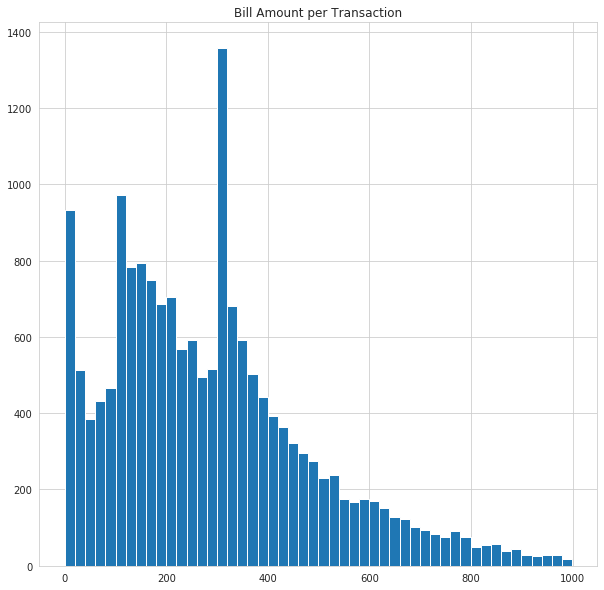

In [101]:
plt.figure(figsize = (10,10))
dat_bills2['TotalAmt'].hist(bins = 50)
plt.title('Bill Amount per Transaction')
plt.show()

The average (median) quantity is 127 (!).

The average bill amount is \\$262, indicating wholesalers (nobody buys \\$200 of gifts every transaction).

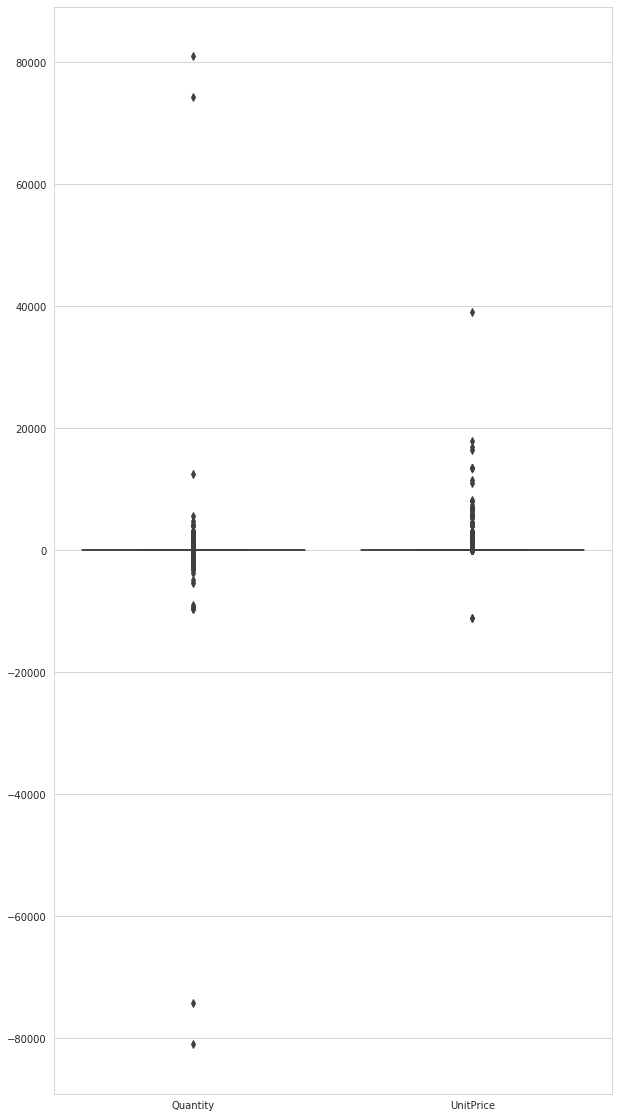

In [102]:
plt.figure(figsize = (10,20))
sns.boxplot(data = dat[['Quantity', 'UnitPrice']])
plt.show()

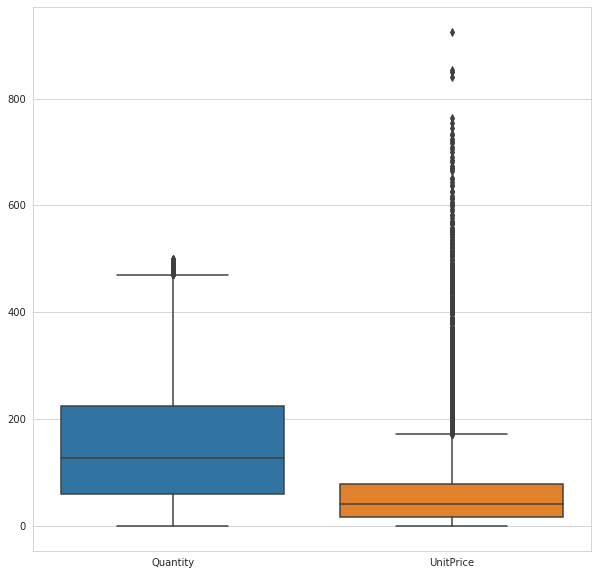

In [103]:
plt.figure(figsize = (10,10))
sns.boxplot(data = dat_bills2[['Quantity', 'UnitPrice']])
plt.show()

### Total Spending per Customer

We will do the same thing as above but this time group by Customer ID. We will again ignore UnitPrice as it is irrelevant when added up.

In [104]:
%time dat_bills3 = dat_bills.groupby('CustomerID').sum()
dat_bills3.head(20)

CPU times: user 48.1 ms, sys: 8.9 ms, total: 57 ms
Wall time: 54.6 ms


,Quantity,UnitPrice,TotalAmt
CustomerID,,,
12346.0,0,2.08,0.00
12347.0,2458,481.21,4310.00
12348.0,2341,178.71,1797.24
12349.0,631,605.10,1757.55
12350.0,197,65.30,334.40
12352.0,470,2211.10,1545.41
12353.0,20,24.30,89.00
12354.0,530,261.22,1079.40
12355.0,240,54.65,459.40


In [105]:
dat_bills3.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
Quantity     4372 non-null int64
UnitPrice    4372 non-null float64
TotalAmt     4372 non-null float64
dtypes: float64(2), int64(1)
memory usage: 136.6 KB


4,372 instances, each corresponding to a customer.

In [106]:
dat_bills3[['Quantity', 'TotalAmt']].describe()

,Quantity,TotalAmt
count,4372.000000,4372.000000
mean,1122.344007,1898.459701
std,4672.790720,8219.345141
min,-303.000000,-4287.630000
25%,153.000000,293.362500
50%,365.000000,648.075000
75%,962.250000,1611.725000
max,196719.000000,279489.020000


Outliers! Let's remove them.

In [107]:
dat_bills3 = dat_bills3[(dat_bills3['TotalAmt'] > 0)
                       & (dat_bills3['TotalAmt'] < 10000)
                       & (dat_bills3['Quantity'] > 0)]

In [108]:
dat_bills3[['Quantity', 'TotalAmt']].describe()

,Quantity,TotalAmt
count,4218.000000,4218.000000
mean,740.494310,1222.650418
std,1025.032517,1515.048641
min,1.000000,2.900000
25%,156.000000,298.027500
50%,360.500000,640.630000
75%,904.500000,1518.917500
max,17280.000000,9861.380000


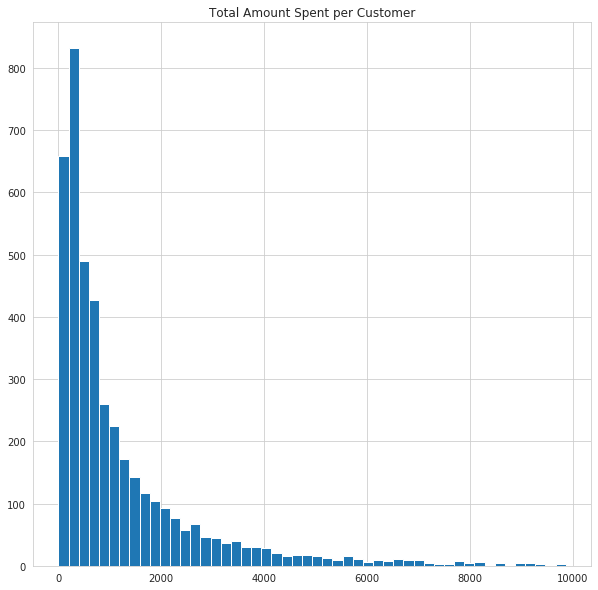

In [109]:
plt.figure(figsize = (10,10))
dat_bills3['TotalAmt'].hist(bins = 50)
plt.title('Total Amount Spent per Customer')
plt.show()

### UK vs. Non-UK

In [110]:
dat['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

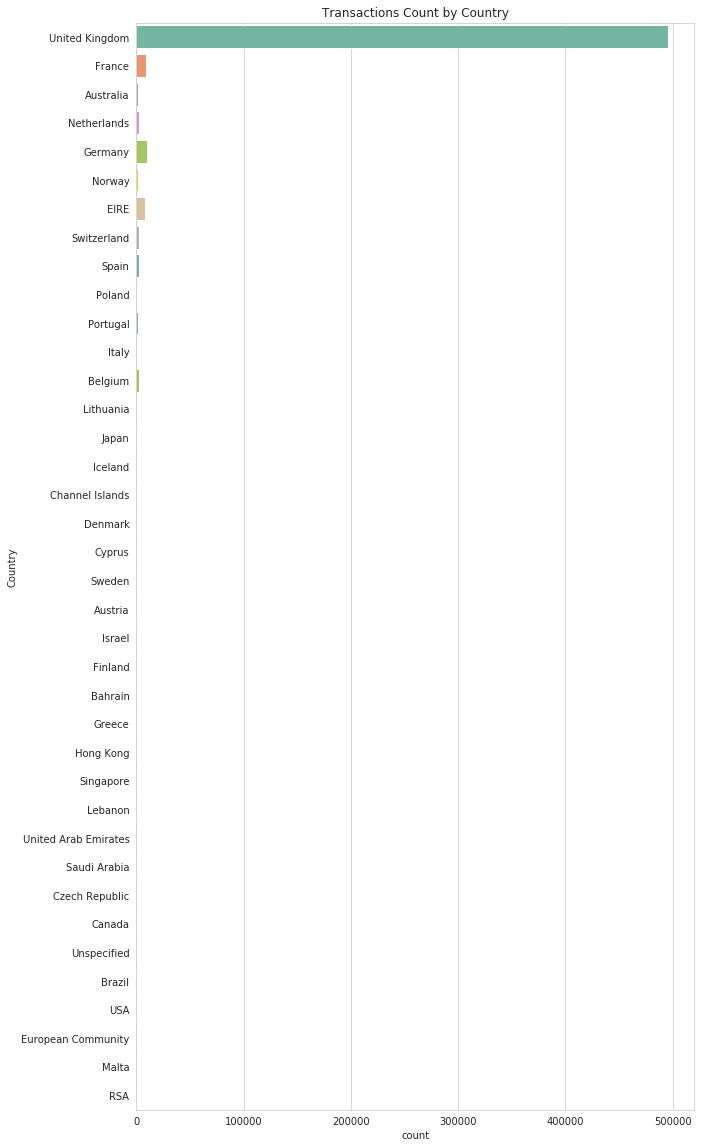

In [111]:
plt.figure(figsize = (10,20))
sns.set_style('whitegrid')
sns.countplot(y = 'Country', data = dat, palette = 'Set2')
plt.title('Transactions Count by Country')
plt.show()

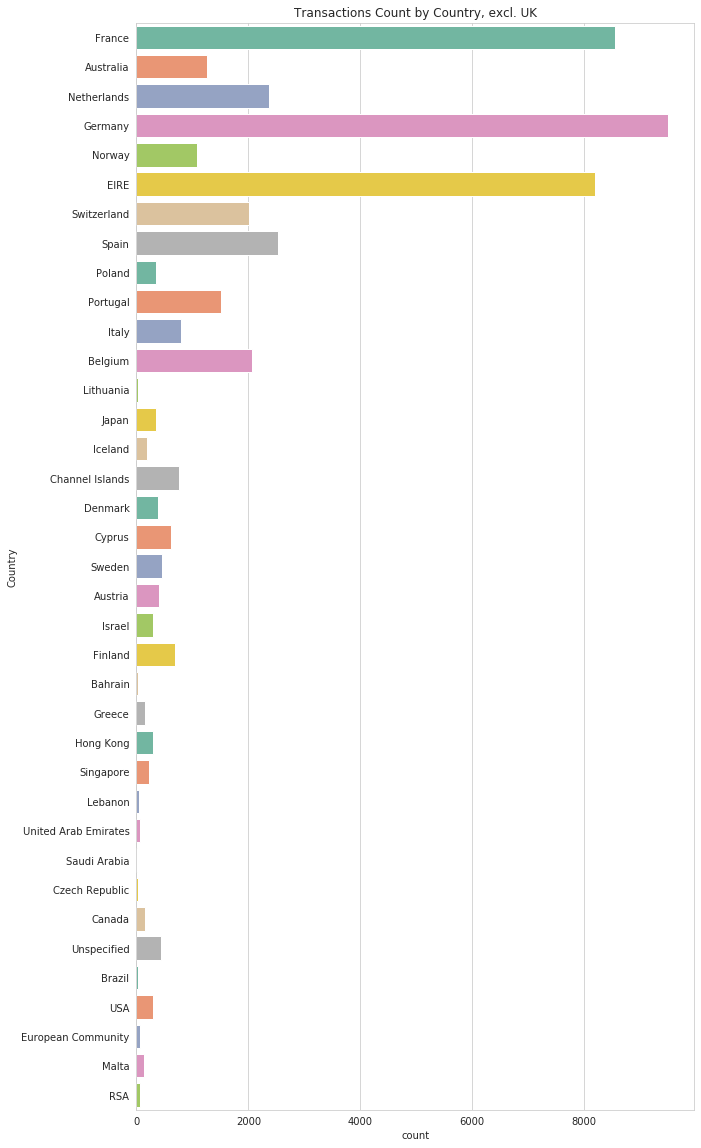

In [112]:
dat_nouk = dat[dat['Country'] != "United Kingdom"].copy()
plt.figure(figsize = (10,20))
sns.set_style('whitegrid')
sns.countplot(y = 'Country', data = dat_nouk, palette = 'Set2')
plt.title('Transactions Count by Country, excl. UK')
plt.show()

In [113]:
dat_countries = dat[['InvoiceNo', 'CustomerID', 'Country']].copy()
dat_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
InvoiceNo     541909 non-null object
CustomerID    406829 non-null float64
Country       541909 non-null object
dtypes: float64(1), object(2)
memory usage: 12.4+ MB


In [114]:
%time dat_countries_t = dat_countries[['InvoiceNo']].join(pd.get_dummies(dat_countries['Country'])).groupby('InvoiceNo').max()
dat_countries_t.head()

CPU times: user 555 ms, sys: 73.1 ms, total: 628 ms
Wall time: 626 ms


,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [115]:
country_transaction_total = pd.DataFrame(dat_countries_t.sum(), columns = ['transactions']).sort_values('transactions', ascending = False).reset_index()
country_transaction_total.head()

,index,transactions
0,United Kingdom,23494
1,Germany,603
2,France,461
3,EIRE,360
4,Belgium,119


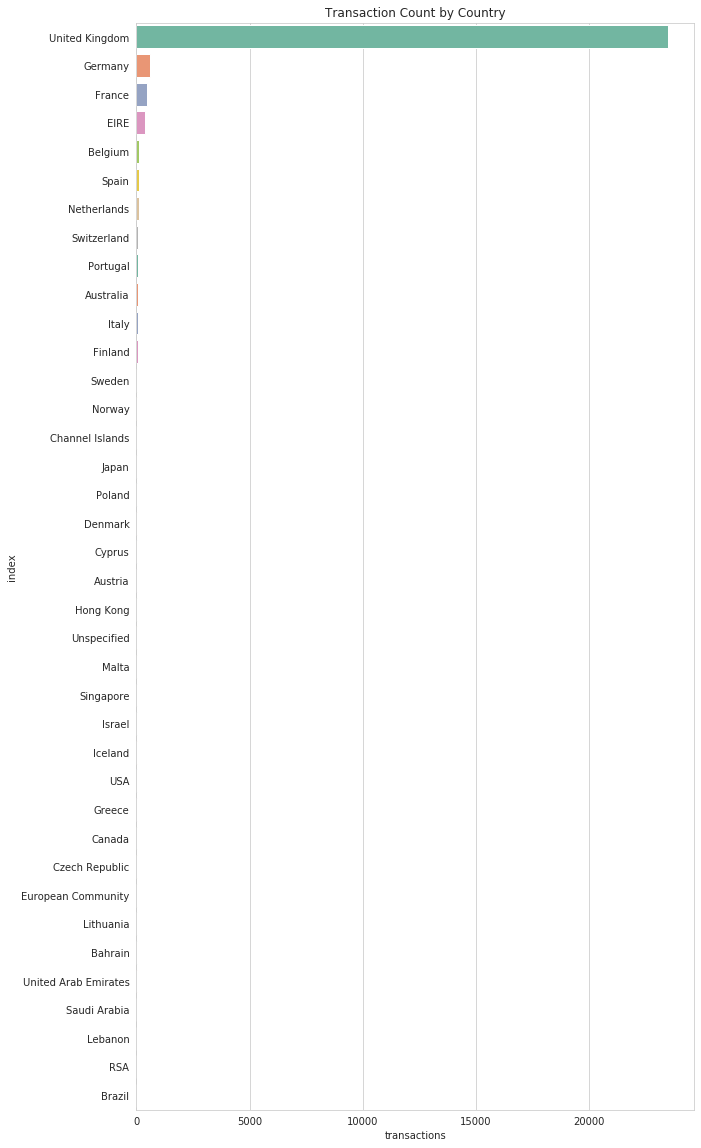

In [116]:
plt.figure(figsize = (10,20))
sns.set_style('whitegrid')
sns.barplot(x = 'transactions', y = 'index', data = country_transaction_total, palette = 'Set2')
plt.title('Transaction Count by Country')
plt.show()

In [117]:
country_transaction_total_nouk = country_transaction_total[country_transaction_total['index'] != 'United Kingdom'].copy()

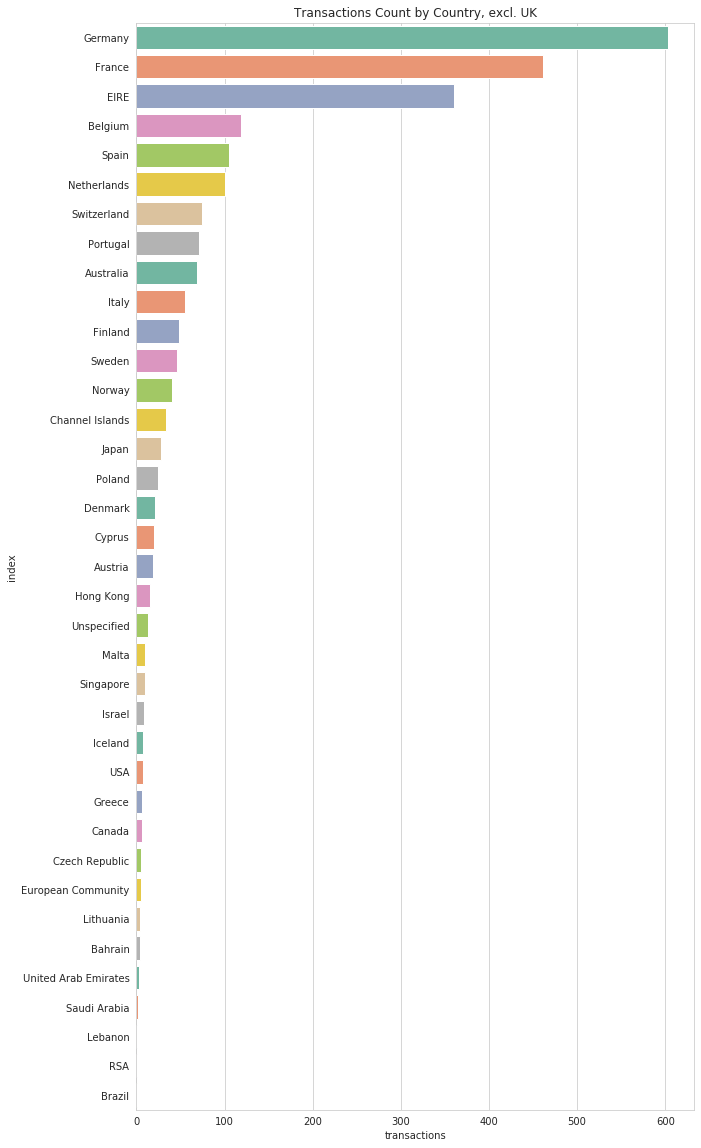

In [118]:
plt.figure(figsize = (10,20))
sns.set_style('whitegrid')
sns.barplot(x = 'transactions', y = 'index', data = country_transaction_total_nouk, palette = 'Set2')
plt.title('Transactions Count by Country, excl. UK')
plt.show()

In [119]:
%time dat_countries_c = dat_countries[['CustomerID']].join(pd.get_dummies(dat_countries['Country'])).groupby('CustomerID').max()
dat_countries_c.head()

CPU times: user 392 ms, sys: 66.1 ms, total: 458 ms
Wall time: 455 ms


,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
country_customer_total = pd.DataFrame(dat_countries_c.sum(), columns = ['customers']).sort_values('customers', ascending = False).reset_index()
country_customer_total.head()

,index,customers
0,United Kingdom,3950
1,Germany,95
2,France,87
3,Spain,31
4,Belgium,25


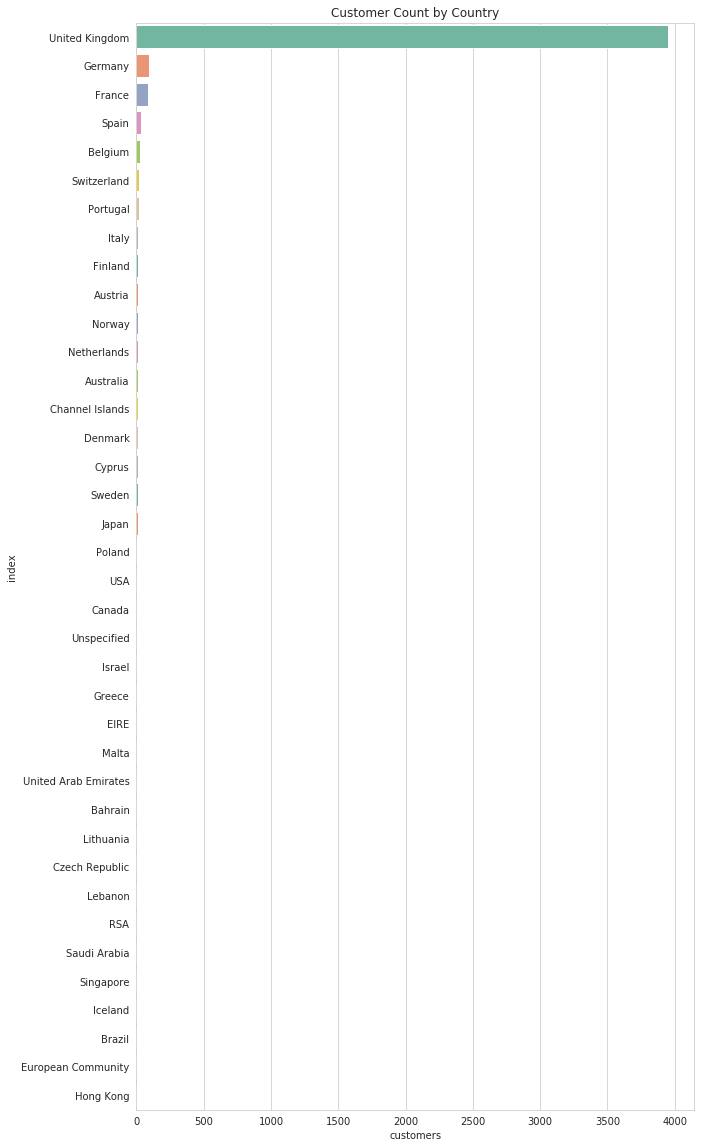

In [121]:
plt.figure(figsize = (10,20))
sns.set_style('whitegrid')
sns.barplot(x = 'customers', y = 'index', data = country_customer_total, palette = 'Set2')
plt.title('Customer Count by Country')
plt.show()

In [122]:
country_customer_total_nouk = country_customer_total[country_customer_total['index'] != 'United Kingdom'].copy()

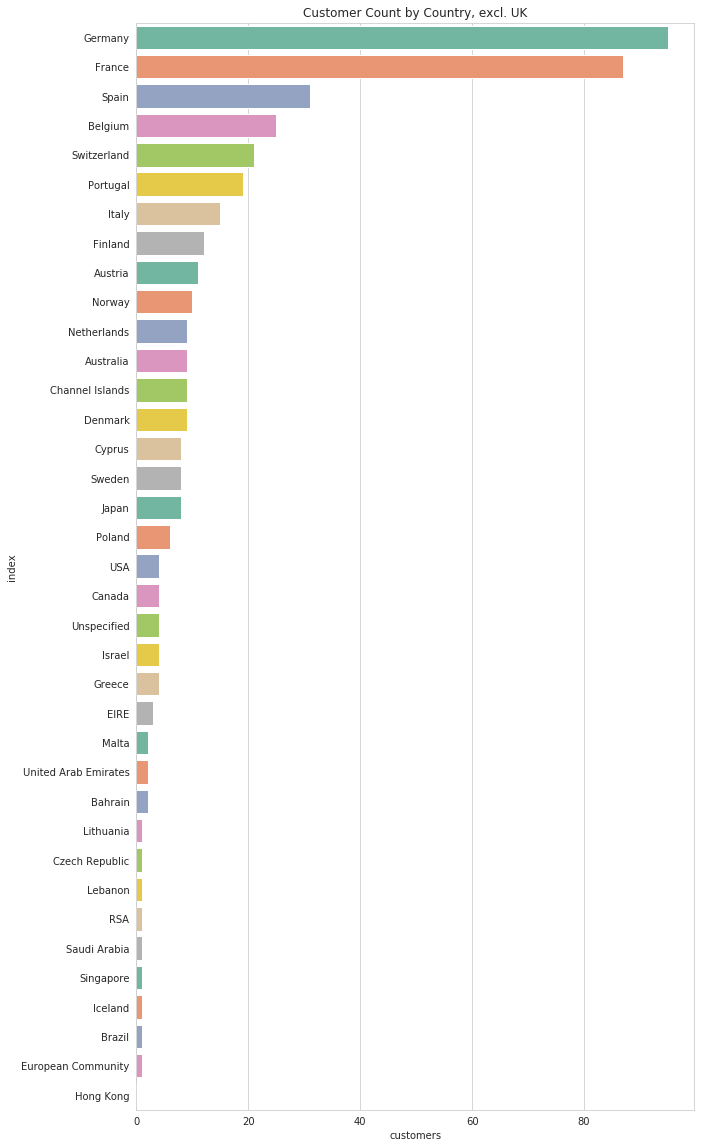

In [123]:
plt.figure(figsize = (10,20))
sns.set_style('whitegrid')
sns.barplot(x = 'customers', y = 'index', data = country_customer_total_nouk, palette = 'Set2')
plt.title('Customer Count by Country, excl. UK')
plt.show()

Attempted to draw a graph below, but plotly doesn't work in JupyterLab without an extension :(

In [124]:
import plotly.express as px
import plotly.graph_objects as go

In [125]:
fig = go.Figure(data=go.Choropleth(
    locations=country_customer_total['index'],
    z = country_customer_total['customers'],
    locationmode = 'country names',
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text='2014 Global GDP',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
        showarrow = False
    )]
)

fig.show()

## Preprocessing for `apriori`

The idea for preprocessing is to group the data by invoice number to get each transaction as an instance. Then we will one-hot encode for ALL of the products in the dataset (all 4,070 of them). Extensive research (by me) have gone into how to best do this, see below.

To speed this up we will create a dataframe with just two columns: InvoiceNo and Description. Alternatively, we can use StockCode, but this is less interpretable (have to translate from StockCode to Description). I played around with this using a dictionary but it's more trouble than it's worth (I am lazy). The downside of using Description is that it's missing 1,454 instances. We will simply drop these.

Huge thanks to [this StackOverflow post](https://stackoverflow.com/questions/46791626/one-hot-encoding-multi-level-column-data) for the below solution. I never paid attention to timing before now.

In [126]:
dat_processed2 = dat[['InvoiceNo', 'Description']].copy()

In [127]:
dat_processed2.isnull().sum()

InvoiceNo         0
Description    1454
dtype: int64

Drop the NA's:

In [128]:
dat_processed2.dropna(inplace = True)
dat_processed2.isnull().sum()

InvoiceNo      0
Description    0
dtype: int64

~~(What caveat are you talking about `pandas`? This is your own function *method* that you wrote!)~~

Turns out I have to create a copy of the two columns from the beginning. This has to do with how Python references things.

Correct:

```python
dat_processed2 = dat[['InvoiceNo', 'Description']].copy()
# now can safely do whatever you want with dat_processed2
```

Incorrect:

```python
dat_processed2 = dat[['InvoiceNo', 'Description']]
# modifying dat_processed2 might modify dat, in rare cases though, because I'm not creating a view a la dat2 = dat.
```

In [129]:
%time dat_encoded2 = dat_processed2[['InvoiceNo']].join(pd.get_dummies(dat_processed2['Description'])).groupby('InvoiceNo').max()

CPU times: user 1min 13s, sys: 10.6 s, total: 1min 24s
Wall time: 1min 24s


## Association Rules with `mlxtend`

### Find frequent itemsets with `apriori`

In [130]:
from mlxtend.frequent_patterns import apriori

Tweak the minimum support here, 0.001 ran forever, 0.005 improved it to 4 min 10s.

In [302]:
%time frequent_itemsets2 = apriori(dat_encoded2, min_support=0.005, use_colnames=True)

CPU times: user 4min 10s, sys: 161 ms, total: 4min 10s
Wall time: 4min 10s


See how many itemsets we have:

In [303]:
frequent_itemsets2.shape

(8483, 2)

See a sample of them:

In [304]:
frequent_itemsets2.tail(10)

,support,itemsets
8473,0.005072,"(LUNCH BAG SUKI DESIGN , LUNCH BAG SPACEBOY DE..."
8474,0.005727,"(LUNCH BAG WOODLAND, LUNCH BAG SPACEBOY DESIGN..."
8475,0.005318,"(LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN , L..."
8476,0.005113,"(LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN , L..."
8477,0.005850,"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE P..."
8478,0.005031,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ..."
8479,0.005277,"(STRAWBERRY CHARLOTTE BAG, PACK OF 72 RETROSPO..."
8480,0.005563,"(REGENCY TEA PLATE ROSES , REGENCY TEA PLATE P..."
8481,0.006463,"(HERB MARKER THYME, HERB MARKER PARSLEY, HERB ..."
8482,0.005031,"(JUMBO BAG TOYS , JUMBO BAG RED RETROSPOT, JUM..."


Since itemsets with one item is not interesting, let's look at interesting ones (with high suport also):

In [305]:
%time frequent_itemsets2['length'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))

CPU times: user 6.13 ms, sys: 1e+03 ns, total: 6.13 ms
Wall time: 5.84 ms


In [306]:
frequent_itemsets2[ (frequent_itemsets2['length'] == 2) &
                   (frequent_itemsets2['support'] >= 0.01) ].tail(10)

,support,itemsets,length
5452,0.011863,"(STRAWBERRY CERAMIC TRINKET BOX, SWEETHEART CE...",2
5458,0.016690,"(STRAWBERRY CHARLOTTE BAG, WOODLAND CHARLOTTE ...",2
5494,0.011822,"(VICTORIAN GLASS HANGING T-LIGHT, WHITE HANGIN...",2
5499,0.013990,"(VINTAGE HEADS AND TAILS CARD GAME , VINTAGE S...",2
5518,0.013949,"(WOODEN FRAME ANTIQUE WHITE , WHITE HANGING HE...",2
5520,0.016772,"(WHITE HANGING HEART T-LIGHT HOLDER, WOODEN PI...",2
5536,0.022294,"(WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F...",2
5537,0.015913,"(WOODEN HEART CHRISTMAS SCANDINAVIAN, WOODEN S...",2
5538,0.010227,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN HE...",2
5539,0.011536,"(WOODEN TREE CHRISTMAS SCANDINAVIAN, WOODEN ST...",2


### Build Association Rules

In [307]:
from mlxtend.frequent_patterns import association_rules
%time rules2 = association_rules(frequent_itemsets2, metric = 'confidence', min_threshold = 0.01)

CPU times: user 514 ms, sys: 21 ms, total: 535 ms
Wall time: 532 ms


In [308]:
rules2["antecedent_len"] = rules2["antecedents"].apply(lambda x: len(x))
rules2["consequent_len"] = rules2["consequents"].apply(lambda x: len(x))
rules2['order'] = rules2['antecedent_len'] + rules2['consequent_len']
rules2.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len,order
0,(SPACEBOY BEAKER),( DOLLY GIRL BEAKER),0.007568,0.007200,0.005113,0.675676,93.849816,0.005059,3.061135,1,1,2
1,( DOLLY GIRL BEAKER),(SPACEBOY BEAKER),0.007200,0.007568,0.005113,0.710227,93.849816,0.005059,3.424864,1,1,2
2,(12 PENCIL SMALL TUBE WOODLAND),(12 PENCILS SMALL TUBE RED RETROSPOT),0.014604,0.014972,0.005441,0.372549,24.883424,0.005222,1.569889,1,1,2
3,(12 PENCILS SMALL TUBE RED RETROSPOT),(12 PENCIL SMALL TUBE WOODLAND),0.014972,0.014604,0.005441,0.363388,24.883424,0.005222,1.547876,1,1,2
4,(12 PENCILS SMALL TUBE SKULL),(12 PENCILS SMALL TUBE RED RETROSPOT),0.014645,0.014972,0.006177,0.421788,28.172192,0.005958,1.703575,1,1,2
5,(12 PENCILS SMALL TUBE RED RETROSPOT),(12 PENCILS SMALL TUBE SKULL),0.014972,0.014645,0.006177,0.412568,28.172192,0.005958,1.677396,1,1,2
6,(GINGERBREAD MAN COOKIE CUTTER),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.027489,0.015749,0.005195,0.188988,12.000008,0.004762,1.213609,1,1,2
7,(3 PIECE SPACEBOY COOKIE CUTTER SET),(GINGERBREAD MAN COOKIE CUTTER),0.015749,0.027489,0.005195,0.329870,12.000008,0.004762,1.451227,1,1,2
8,(SET OF 3 BUTTERFLY COOKIE CUTTERS),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.028471,0.015749,0.005931,0.208333,13.228355,0.005483,1.243264,1,1,2
9,(3 PIECE SPACEBOY COOKIE CUTTER SET),(SET OF 3 BUTTERFLY COOKIE CUTTERS),0.015749,0.028471,0.005931,0.376623,13.228355,0.005483,1.558495,1,1,2


In [309]:
rules2.shape

(33560, 12)

In [310]:
type(rules2)

pandas.core.frame.DataFrame

Again let's look at interesting association rules, for example with confidence of > 0.75 and lift of > 1.2:

In [311]:
rules2[ (rules2['antecedent_len'] >= 2) &
       (rules2['confidence'] > 0.75) &
       (rules2['lift'] > 1.2) ].tail(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len,order
33489,"(HERB MARKER ROSEMARY, HERB MARKER CHIVES )","(HERB MARKER THYME, HERB MARKER MINT, HERB MAR...",0.007772,0.007281,0.006463,0.831579,114.206623,0.006407,5.894267,2,4,6
33490,"(HERB MARKER BASIL, HERB MARKER CHIVES )","(HERB MARKER ROSEMARY, HERB MARKER THYME, HERB...",0.007486,0.007650,0.006463,0.863388,112.868356,0.006406,7.264006,2,4,6
33498,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG WOODLAND ANIMALS),0.006095,0.035670,0.005031,0.825503,23.142494,0.004814,5.526350,5,1,6
33499,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG PINK POLKADOT),0.005809,0.050356,0.005031,0.866197,17.201508,0.004739,7.097340,5,1,6
33500,"(JUMBO BAG TOYS , JUMBO SHOPPER VINTAGE RED PA...",(JUMBO STORAGE BAG SUKI),0.005563,0.049129,0.005031,0.904412,18.409034,0.004758,9.947577,5,1,6
33501,"(JUMBO BAG RED RETROSPOT, JUMBO STORAGE BAG SU...",(JUMBO SHOPPER VINTAGE RED PAISLEY),0.005972,0.048556,0.005031,0.842466,17.350394,0.004742,6.039601,5,1,6
33502,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO STOR...",(JUMBO BAG RED RETROSPOT),0.005522,0.087335,0.005031,0.911111,10.432329,0.004549,10.267477,5,1,6
33510,"(JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SU...","(JUMBO BAG WOODLAND ANIMALS, JUMBO BAG RED RET...",0.006668,0.022008,0.005031,0.754601,34.288070,0.004885,3.985319,4,2,6
33512,"(JUMBO BAG PINK POLKADOT, JUMBO BAG WOODLAND A...","(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)",0.006095,0.029984,0.005031,0.825503,27.531044,0.004849,5.558935,4,2,6
33513,"(JUMBO BAG PINK POLKADOT, JUMBO STORAGE BAG SU...","(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",0.006545,0.027939,0.005031,0.768750,27.515172,0.004849,4.203506,4,2,6


In [312]:
rules2[ (rules2['antecedent_len'] >= 2) &
       (rules2['confidence'] > 0.75) &
       (rules2['lift'] > 2) ].shape

(2682, 12)

In [313]:
rules2.sort_values('lift', ascending = True).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len,order
4379,(REGENCY CAKESTAND 3 TIER),(JUMBO BAG PINK POLKADOT),0.088726,0.050356,0.005563,0.062702,1.245171,0.001095,1.013172,1,1,2
4378,(JUMBO BAG PINK POLKADOT),(REGENCY CAKESTAND 3 TIER),0.050356,0.088726,0.005563,0.110479,1.245171,0.001095,1.024455,1,1,2
695,(ASSORTED COLOUR BIRD ORNAMENT),(JUMBO BAG RED RETROSPOT),0.060010,0.087335,0.006750,0.112474,1.287845,0.001509,1.028325,1,1,2
694,(JUMBO BAG RED RETROSPOT),(ASSORTED COLOUR BIRD ORNAMENT),0.087335,0.060010,0.006750,0.077283,1.287845,0.001509,1.018720,1,1,2
7259,(POSTAGE),(REGENCY CAKESTAND 3 TIER),0.051133,0.088726,0.006422,0.125600,1.415591,0.001885,1.042170,1,1,2
7258,(REGENCY CAKESTAND 3 TIER),(POSTAGE),0.088726,0.051133,0.006422,0.072384,1.415591,0.001885,1.022909,1,1,2
4086,(JUMBO BAG APPLES),(REGENCY CAKESTAND 3 TIER),0.040866,0.088726,0.005400,0.132132,1.489213,0.001774,1.050014,1,1,2
4087,(REGENCY CAKESTAND 3 TIER),(JUMBO BAG APPLES),0.088726,0.040866,0.005400,0.060858,1.489213,0.001774,1.021287,1,1,2
4661,(JUMBO BAG RED RETROSPOT),(REGENCY CAKESTAND 3 TIER),0.087335,0.088726,0.011781,0.134895,1.520347,0.004032,1.053367,1,1,2
4660,(REGENCY CAKESTAND 3 TIER),(JUMBO BAG RED RETROSPOT),0.088726,0.087335,0.011781,0.132780,1.520347,0.004032,1.052403,1,1,2


Honestly I'm not sure what we can get out of this. There are 2,682 association rules with confidence > 0.75 and lift > 1.2. This can be fed into the recommender system, but there is no way for a human to comb through 2,116 rules and see what is interesting and what's not.

I suppose we can just write into the report that we have a bunch of association rules that will recommend items (consequent) on the detail page for the antecedent products. In addition, it can recommend items in the shopping cart page based on the content of the shopping cart, using rules with antecedents of length > 2.

In [333]:
rules2.to_csv('rules.csv')

In [314]:
rules2.loc[230, 'antecedents'] == frozenset({'ALARM CLOCK BAKELIKE PINK'})

False

### Another Function, perhaps?

Let's make a function to recommend the item with the highest lift to deploy.

In [326]:
def recommend_arules(product, ruleset):
    '''
    (str, Data) -> NoneType
    '''
    
    print('For: {}'.format(product))
    
    try:
        frozen = frozenset({product})
        relevant_rules = ruleset[ruleset['antecedents'] == frozen].copy()
        relevant_rules.sort_values(by = 'lift', ascending = False, inplace = True)
        print('Recommended: {}'.format(list(relevant_rules.iloc[0, 1])))
        #return relevant_rules.iloc[0, 1]
    except IndexError:
        print('No Rules Found!')
        
    print('\n-----------\n')

In [321]:
a = list(dat.iloc[2030:2100, 2])
'''for thing in a:
    print(thing)'''

'for thing in a:\n    print(thing)'

In [317]:
rules2[rules2['antecedents'] == frozenset({a[2]})]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequent_len,order


In [318]:
recommend_arules(a[2], rules2)

For: CREAM CUPID HEARTS COAT HANGER
No Rules Found!

-----------



In [327]:
for item in a:
    recommend_arules(item, rules2)

For: CHRISTMAS MUSICAL ZINC HEART 
No Rules Found!

-----------

For: DOVE DECORATION PAINTED ZINC 
No Rules Found!

-----------

For: UNION STRIPE WITH FRINGE  HAMMOCK
No Rules Found!

-----------

For: FOLKART ZINC HEART CHRISTMAS DEC
No Rules Found!

-----------

For: RED RETROSPOT CAKE STAND
Recommended: ['REGENCY CAKESTAND 3 TIER']

-----------

For: ASSORTED COLOUR MINI CASES
Recommended: ['RED RETROSPOT MINI CASES']

-----------

For: WICKER STAR 
Recommended: ['HEART OF WICKER LARGE']

-----------

For: SKULLS AND CROSSBONES WRAP
No Rules Found!

-----------

For: POLYESTER FILLER PAD 45x30cm
No Rules Found!

-----------

For: POLYESTER FILLER PAD 40x40cm
No Rules Found!

-----------

For: 3D CHRISTMAS STAMPS STICKERS 
No Rules Found!

-----------

For: VICTORIAN SEWING BOX LARGE
No Rules Found!

-----------

For: RED RETROSPOT OVEN GLOVE DOUBLE
No Rules Found!

-----------

For: PINK FLOWER FABRIC PONY
No Rules Found!

-----------

For: METAL 4 HOOK HANGER FRENCH CHATEAU
Recom

## Visualization

I'll have to manually create the graphs that Steve showed in his slides.

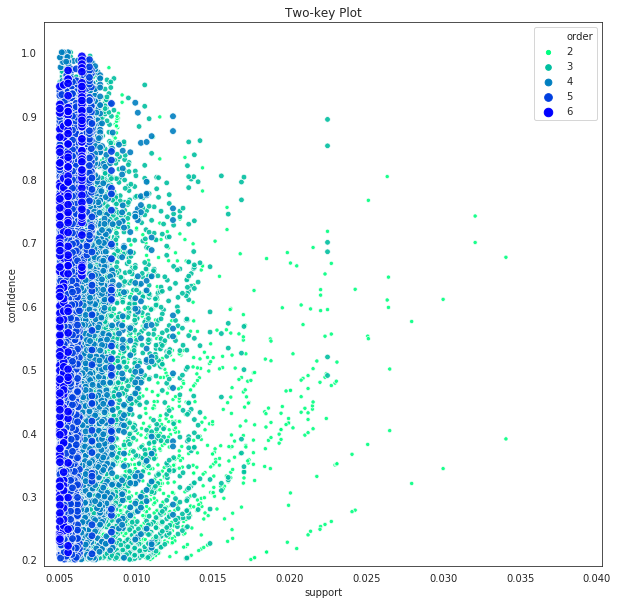

In [45]:
fig = plt.figure(figsize = (10,10))
pal = sns.cubehelix_palette(5, start = 2.6, rot = .1, gamma = 1)
sns.set_style("white")
sns.scatterplot(x = 'support', y = 'confidence', data = rules2, hue = 'order', palette = 'winter_r', legend = 'full', size = 'order', alpha = .9)
plt.xlim(left = 0.004)
plt.ylim(bottom = 0.19)
plt.title('Two-key Plot')
plt.show()

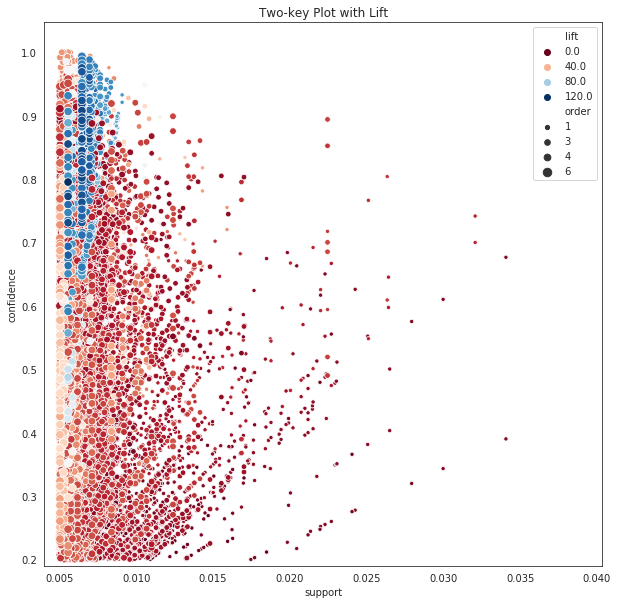

In [46]:
hilift = rules2[rules2['lift'] > 1].copy()
fig = plt.figure(figsize = (10,10))
sns.set_style("white")
pal = sns.cubehelix_palette(start = 2.5, rot = .1, gamma = 1.25, hue = 1, as_cmap=True)
sns.scatterplot(x = 'support', y = 'confidence', data = hilift, hue = 'lift', palette = 'RdBu', size = 'order')
plt.xlim(left = 0.004)
plt.ylim(bottom = 0.19)
plt.title('Two-key Plot with Lift')
plt.show()

## Recommender System - Using `lightfm`

After a bit of research I found that `lightfm` is actually well-equipped to perform on implicit ratings. `surprise`... not so much.

There is so little resources on this, I wonder if it is THAT popular... Netflix uses SVD++ (I think) but things are limited when there is no explicit feedback.

So `lightfm` is a package that specializes in *latent matrix factorization*, super interesting stuff.

In [168]:
dat_rs3 = dat[['CustomerID', 'Description']].copy()
dat_rs3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 2 columns):
CustomerID     406829 non-null float64
Description    540455 non-null object
dtypes: float64(1), object(1)
memory usage: 8.3+ MB


Remove NA's:

In [169]:
dat_rs3.dropna(inplace = True)
dat_rs3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 2 columns):
CustomerID     406829 non-null float64
Description    406829 non-null object
dtypes: float64(1), object(1)
memory usage: 9.3+ MB


Create a list of 1's:

In [170]:
ratings = [1]*406829

Add to our dataframe as a "Rating" column and make sure everything is OK:

In [171]:
dat_rs3['Rating'] = ratings
dat_rs3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 3 columns):
CustomerID     406829 non-null float64
Description    406829 non-null object
Rating         406829 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.4+ MB


In [172]:
dat_rs3.head(10)

,CustomerID,Description,Rating
0,17850.0,WHITE HANGING HEART T-LIGHT HOLDER,1
1,17850.0,WHITE METAL LANTERN,1
2,17850.0,CREAM CUPID HEARTS COAT HANGER,1
3,17850.0,KNITTED UNION FLAG HOT WATER BOTTLE,1
4,17850.0,RED WOOLLY HOTTIE WHITE HEART.,1
5,17850.0,SET 7 BABUSHKA NESTING BOXES,1
6,17850.0,GLASS STAR FROSTED T-LIGHT HOLDER,1
7,17850.0,HAND WARMER UNION JACK,1
8,17850.0,HAND WARMER RED POLKA DOT,1
9,13047.0,ASSORTED COLOUR BIRD ORNAMENT,1


In [328]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k
from lightfm.cross_validation import random_train_test_split

In [174]:
%time dat_rs4 = dat_rs3[['CustomerID']].join(pd.get_dummies(dat_processed2['Description'])).groupby('CustomerID').max()

CPU times: user 49.6 s, sys: 8.2 s, total: 57.8 s
Wall time: 58 s


In [175]:
dat_rs4_sparse = scipy.sparse.csr_matrix(dat_rs4.values)

Split train and test, train model on train and test on test. Then look at AUC.

LightFM has a handy dandy function that works directly on sparse matrices.

In [176]:
train, test = random_train_test_split(dat_rs4_sparse)

In [177]:
lfm_train = LightFM()
lfm_train.fit(train)

%time auc_score(lfm_train, train).mean()

CPU times: user 4.38 s, sys: 1.01 ms, total: 4.38 s
Wall time: 4.38 s


0.83335084

In [178]:
%time auc_score(lfm_train, test).mean()

CPU times: user 1.86 s, sys: 1.05 ms, total: 1.86 s
Wall time: 1.86 s


0.82771873

#### Results:

Dataset|AUC
:---:|---:
Train | 0.8336978
Test | 0.82675457

looks good, now train on entire data and make predictions:

In [179]:
lfm = LightFM(learning_rate=0.05, loss='warp')
lfm.fit(dat_rs4_sparse)

In [180]:
%time auc_score(lfm, dat_rs4_sparse).mean()

CPU times: user 5.19 s, sys: 22 µs, total: 5.19 s
Wall time: 5.19 s


0.8356036

In [181]:
lfm.predict(0,[0])

array([-1.27405131])

In [182]:
dat_rs4.shape

(4372, 4223)

In [183]:
dat_rs4_sparse.shape

(4372, 4223)

In [184]:
dat_rs4.head(10)

,20713,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12353.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12354.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12355.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [334]:
len(dat_rs4)

4372

In [221]:
dat_rs4.sum(axis = 1)

CustomerID
12346.0      1
12347.0    103
12348.0     22
12349.0     73
12350.0     17
12352.0     59
12353.0      4
12354.0     58
12355.0     13
12356.0     53
12357.0    131
12358.0     13
12359.0    213
12360.0    105
12361.0     10
12362.0    201
12363.0     23
12364.0     70
12365.0     22
12367.0     11
12370.0    143
12371.0     63
12372.0     34
12373.0     14
12374.0     33
12375.0     14
12377.0     72
12378.0    219
12379.0     39
12380.0     77
          ... 
18245.0    155
18246.0      3
18248.0     39
18249.0      8
18250.0     21
18251.0     16
18252.0     90
18255.0      6
18256.0      4
18257.0    101
18259.0     27
18260.0     86
18261.0     19
18262.0     13
18263.0     58
18265.0     44
18268.0      1
18269.0      7
18270.0     12
18272.0    101
18273.0      1
18274.0     11
18276.0     14
18277.0      9
18278.0      9
18280.0     10
18281.0      7
18282.0     12
18283.0    272
18287.0     59
Length: 4372, dtype: int64

In [185]:
n_users, n_items = dat_rs4_sparse.shape

In [186]:
scores = lfm.predict(3, np.arange(n_items))
scores.shape

(4223,)

In [187]:
item_names = dat_rs4.columns

In [188]:
item_names[0]

20713

In [189]:
top_items = item_names[np.argsort(-scores)]

In [190]:
top_items[:10]

Index(['WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER',
       'JAM MAKING SET WITH JARS', 'PARTY BUNTING',
       'PACK OF 72 RETROSPOT CAKE CASES', 'SET OF 3 CAKE TINS PANTRY DESIGN ',
       'ASSORTED COLOUR BIRD ORNAMENT', 'JAM MAKING SET PRINTED',
       'RECIPE BOX PANTRY YELLOW DESIGN', 'SPOTTY BUNTING'],
      dtype='object')

In [191]:
test234 = pd.DataFrame(item_names)

In [192]:
test234['Scores'] = scores

In [193]:
%time test234.sort_values('Scores', ascending = False)[:9]

CPU times: user 2.49 ms, sys: 0 ns, total: 2.49 ms
Wall time: 2.19 ms


,0,Scores
3918,WHITE HANGING HEART T-LIGHT HOLDER,1.634655
2915,REGENCY CAKESTAND 3 TIER,1.606832
1833,JAM MAKING SET WITH JARS,1.481079
2471,PARTY BUNTING,1.465989
2395,PACK OF 72 RETROSPOT CAKE CASES,1.461507
3195,SET OF 3 CAKE TINS PANTRY DESIGN,1.447289
244,ASSORTED COLOUR BIRD ORNAMENT,1.385970
1832,JAM MAKING SET PRINTED,1.380854
2812,RECIPE BOX PANTRY YELLOW DESIGN,1.360734


Create a function to automatically recommend the top 9 items for a given user:

**NOTE:** Function performance is pretty bad, but it works. Obviously in a real setting I would optimize it... :D

In [349]:
def recommend_lfm(model, data, user, n_pred = 9, limit_old = True):
    '''
    (LightFM, DataFrame, int, int, bool) -> NoneType
    
    Rudimentary function.
    From a LightFM model object, output the top n recommended items for a given user.
    This will ensure at least 5 "new" items by removing all the "old" items from the output DF once the count is up to 4.
    
    Parameters:
    - model: the LightFM object.
    - data: the DataFrame with the data. This is used to get the user and item names.
    - user: the index of the user. Note this is **not** the actual user ID, but the position of the user within the data.
    - n_pred: number of products to recommend.
    '''
    n_users, n_items = data.shape
    item_names = data.columns
    user_names = data.index
    scores = model.predict(user, np.arange(n_items))
    
    top = pd.DataFrame(item_names, columns = ['Description'])
    top['Score'] = scores
    top.sort_values('Score', ascending = False, inplace = True)
    
    status = []    
    for i in top['Description']:
        item_status = data.loc[user_names[user], i]
        status = status + [item_status]
        '''if item_status == 1:
            status = status + ['Old']
        else:
            status = status + ['New']'''
        
    top['Status'] = status
    
    # Remove old items once count is 4
    if limit_old == True:
        n_rows = len(top.index)
        top['Remove'] = [False] * len(top.index)
        total = 0
        for i in range(0, 100):
            row = top.iloc[i]
            # print(str(total) + ' status: ' + str(row['Status']))
            if (total >= 4) and (row['Status'] == 1):
                # print(top.iat[i, 3])
                top.iat[i, 3] = True
            total = total + row['Status']

        top_new = top[top['Remove'] == False].copy()
        top_new.drop('Remove', axis = 1, inplace = True)
    else:
        top_new = top.copy()
        
    top_new['Status'] = top_new['Status'].replace([0, 1], ['New', 'Old'])
            
    print('User ID: ' + str(user_names[user]))
    print(top_new[:n_pred])
    #print(top_new['Status'][:n_pred].value_counts())
    print('\n---------------------\n')
    
    #return top[:n_pred]

In [341]:
recommend_lfm(lfm, dat_rs4, 5, 20, False)

User ID: 12352.0
                             Description     Score Status
3918  WHITE HANGING HEART T-LIGHT HOLDER  1.526758    New
2915            REGENCY CAKESTAND 3 TIER  1.437788    Old
2471                       PARTY BUNTING  1.304762    New
244        ASSORTED COLOUR BIRD ORNAMENT  1.283233    New
3195   SET OF 3 CAKE TINS PANTRY DESIGN   1.274736    Old
1833            JAM MAKING SET WITH JARS  1.239434    New
2812     RECIPE BOX PANTRY YELLOW DESIGN  1.195286    New
2395     PACK OF 72 RETROSPOT CAKE CASES  1.194350    New
2253     NATURAL SLATE HEART CHALKBOARD   1.154077    New
3524                      SPOTTY BUNTING  1.142071    Old
1832              JAM MAKING SET PRINTED  1.095094    New
2439     PAPER CHAIN KIT 50'S CHRISTMAS   1.093407    New
1866             JUMBO BAG RED RETROSPOT  1.079296    New
1709               HEART OF WICKER LARGE  1.066069    New
3984   WOODEN PICTURE FRAME WHITE FINISH  1.008442    New
304        BAKING SET 9 PIECE RETROSPOT   0.999655    O

In [211]:
recommend_lfm(lfm, dat_rs4, 5, 20)

                             Description     Score Status
3918  WHITE HANGING HEART T-LIGHT HOLDER  1.526758    New
2915            REGENCY CAKESTAND 3 TIER  1.437788    Old
2471                       PARTY BUNTING  1.304762    New
244        ASSORTED COLOUR BIRD ORNAMENT  1.283233    New
3195   SET OF 3 CAKE TINS PANTRY DESIGN   1.274736    Old
1833            JAM MAKING SET WITH JARS  1.239434    New
2812     RECIPE BOX PANTRY YELLOW DESIGN  1.195286    New
2395     PACK OF 72 RETROSPOT CAKE CASES  1.194350    New
2253     NATURAL SLATE HEART CHALKBOARD   1.154077    New
3524                      SPOTTY BUNTING  1.142071    Old
1832              JAM MAKING SET PRINTED  1.095094    New
2439     PAPER CHAIN KIT 50'S CHRISTMAS   1.093407    New
1866             JUMBO BAG RED RETROSPOT  1.079296    New
1709               HEART OF WICKER LARGE  1.066069    New
3984   WOODEN PICTURE FRAME WHITE FINISH  1.008442    New
304        BAKING SET 9 PIECE RETROSPOT   0.999655    Old
2054          

In [343]:
%%time
for u in range(0, 100):
    recommend_lfm(lfm, dat_rs4, u, 9, False)

User ID: 12346.0
                             Description     Score Status
3918  WHITE HANGING HEART T-LIGHT HOLDER  1.527327    New
2915            REGENCY CAKESTAND 3 TIER  1.522128    New
2471                       PARTY BUNTING  1.364972    New
244        ASSORTED COLOUR BIRD ORNAMENT  1.349564    New
2253     NATURAL SLATE HEART CHALKBOARD   1.274153    New
1866             JUMBO BAG RED RETROSPOT  1.234605    New
3195   SET OF 3 CAKE TINS PANTRY DESIGN   1.219499    New
2439     PAPER CHAIN KIT 50'S CHRISTMAS   1.183204    New
304        BAKING SET 9 PIECE RETROSPOT   1.175571    New

---------------------

User ID: 12347.0
                             Description     Score Status
3918  WHITE HANGING HEART T-LIGHT HOLDER  1.139059    New
2915            REGENCY CAKESTAND 3 TIER  1.138981    Old
2471                       PARTY BUNTING  0.951230    New
3195   SET OF 3 CAKE TINS PANTRY DESIGN   0.929489    New
2395     PACK OF 72 RETROSPOT CAKE CASES  0.916094    New
2439     PAPER

In [350]:
%%time
for u in range(0, 100):
    recommend_lfm(lfm, dat_rs4, u, 9, True)

User ID: 12346.0
                             Description     Score Status
3918  WHITE HANGING HEART T-LIGHT HOLDER  1.527327    New
2915            REGENCY CAKESTAND 3 TIER  1.522128    New
2471                       PARTY BUNTING  1.364972    New
244        ASSORTED COLOUR BIRD ORNAMENT  1.349564    New
2253     NATURAL SLATE HEART CHALKBOARD   1.274153    New
1866             JUMBO BAG RED RETROSPOT  1.234605    New
3195   SET OF 3 CAKE TINS PANTRY DESIGN   1.219499    New
2439     PAPER CHAIN KIT 50'S CHRISTMAS   1.183204    New
304        BAKING SET 9 PIECE RETROSPOT   1.175571    New

---------------------

User ID: 12347.0
                             Description     Score Status
3918  WHITE HANGING HEART T-LIGHT HOLDER  1.139059    New
2915            REGENCY CAKESTAND 3 TIER  1.138981    Old
2471                       PARTY BUNTING  0.951230    New
3195   SET OF 3 CAKE TINS PANTRY DESIGN   0.929489    New
2395     PACK OF 72 RETROSPOT CAKE CASES  0.916094    New
2439     PAPER